In [1]:
import numpy as np
import pandas as pd
import random
import os
import sys
import matplotlib.pyplot as plt

from keras.optimizers import Adam
from keras.callbacks import LearningRateScheduler
from keras.callbacks import EarlyStopping, ModelCheckpoint, ReduceLROnPlateau
from keras import backend as K
from keras.metrics import binary_crossentropy

from sklearn.model_selection import train_test_split

# data preparation for dicty
from prepare_data import *

sys.path.insert(0, os.getcwd().rsplit('/',1)[0])
import loops_utils

# load unet model
from unet_model import *

Using TensorFlow backend.


In [2]:
%matplotlib inline

Custom metrics

In [24]:
def iou(y_true, y_pred, smooth=1):
    y_pred = K.round(y_pred) ###
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum( y_pred_f) - intersection
    iou = (intersection + smooth) / (union + smooth)
    return iou

def f1(y_true, y_pred):
    y_pred = K.round(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    tp = K.sum(y_true_f*y_pred_f)
    fp = K.sum((1-y_true_f)*y_pred_f)
    fn = K.sum(y_true_f*(1-y_pred_f))

    p = tp / (tp + fp + K.epsilon())
    r = tp / (tp + fn + K.epsilon())

    return 2*p*r / (p+r+K.epsilon())

def bce_dice_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + dice_coef_loss(y_true, y_pred)

smooth = 1.

def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) + smooth)


def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

def kulch_coef(y_true, y_pred, smooth=1):
    y_pred = K.round(y_pred)
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    
    intersection = K.sum(y_true_f * y_pred_f)
    return (intersection + smooth) / (K.sum(y_true_f) + K.sum(y_pred_f) - 2*intersection + smooth)

def kulch_coef_loss(y_true, y_pred):
    return 1-kulch_coef(y_true, y_pred)

def bce_kulch_loss(y_true, y_pred):
    return binary_crossentropy(y_true, y_pred) + kulch_coef_loss(y_true, y_pred)

In [4]:
X, y = prepare_data(image_size=256, chromosomes=[1,5,6], is_mask_corner_peak=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

In [5]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=bce_dice_loss, metrics=['accuracy'])

weights_path = 'weights/unet_bcr_dice_loss_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


In [6]:
results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

Instructions for updating:
Use tf.cast instead.
Train on 42 samples, validate on 11 samples
Epoch 1/100
42/42 [==============================] - 232s 6s/step - loss: 1.1971 - acc: 0.9697 - val_loss: 1.0132 - val_acc: 0.9982

Epoch 00001: val_loss improved from inf to 1.01325, saving model to weights/unet_bcr_dice_loss_corner_peak_half_step.h5
Epoch 2/100
42/42 [==============================] - 213s 5s/step - loss: 1.0473 - acc: 0.9980 - val_loss: 1.0422 - val_acc: 0.9982

Epoch 00002: val_loss did not improve from 1.01325
Epoch 3/100
42/42 [==============================] - 213s 5s/step - loss: 1.0276 - acc: 0.9980 - val_loss: 1.0248 - val_acc: 0.9982

Epoch 00003: ReduceLROnPlateau reducing learning rate to 0.00010000000474974513.

Epoch 00003: val_loss did not improve from 1.01325
Epoch 4/100
42/42 [==============================] - 212s 5s/step - loss: 1.0216 - acc: 0.9980 - val_loss: 1.0224 - val_acc: 0.9982

Epoch 00004: val_loss did not improve from 1.01325
Epoch 5/100
42/42 [==

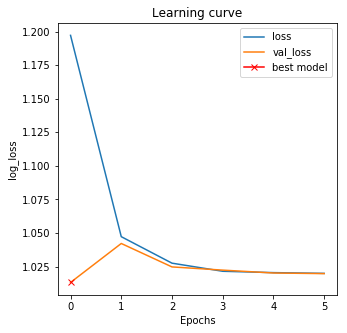

In [7]:
plot_model_scores(results)

In [8]:
model.load_weights(weights_path)
score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

Test score: 1.0216208696365356
Test accuracy: 0.9982355237007141


In [9]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

11/11 [==============================] - 18s 2s/step


In [10]:
# Threshold predictions
t = 0.1
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:74: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


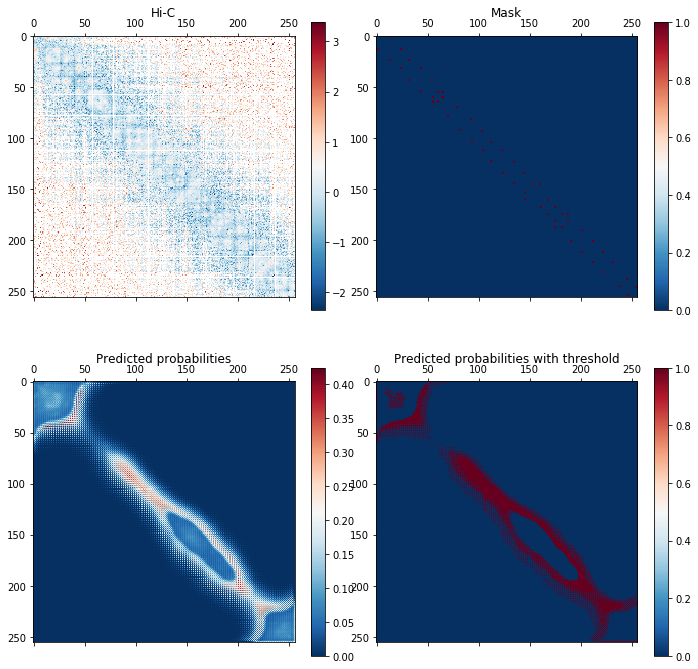

In [11]:
index = 1
loops_utils.plot_prediction_HiC(X_train[index],
                                y_train[index],
                                preds_train[index],
                                preds_train_t[index],
                                image_size=256)

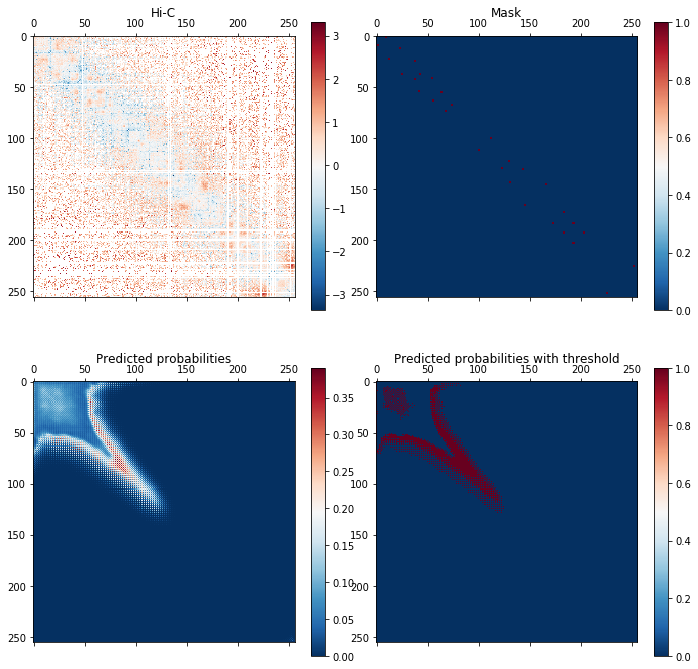

In [12]:
index = 0
loops_utils.plot_prediction_HiC(X_test[index],
                                y_test[index],
                                preds_test[index],
                                preds_test_t[index],
                                image_size=256)

In [25]:
input_img = Input((256, 256, 1), name='img')
model = get_unet(input_img, n_filters=64, dropout=0.05, batchnorm=True)

model.compile(optimizer=Adam(), loss=dice_coef_loss, metrics=['accuracy'])

weights_path = 'weights/unet_dice_corner_peak_half_step.h5'

callbacks = [
    EarlyStopping(patience=5, verbose=1),
    ReduceLROnPlateau(factor=0.1, patience=2, min_lr=0.00001, verbose=1),
    ModelCheckpoint(weights_path, verbose=1, save_best_only=True, save_weights_only=True)
]

In [26]:
results = model.fit(X_train, y_train,
                    batch_size=1, epochs=100,
                    callbacks=callbacks, 
                    validation_data=(X_test, y_test))

Train on 42 samples, validate on 11 samples
Epoch 1/100
42/42 [==============================] - 238s 6s/step - loss: -0.0179 - acc: 0.8091 - val_loss: -0.0086 - val_acc: 0.7949

Epoch 00001: val_loss improved from inf to -0.00857, saving model to weights/unet_dice_corner_peak_half_step.h5
Epoch 2/100
42/42 [==============================] - 213s 5s/step - loss: -0.0616 - acc: 0.9725 - val_loss: -0.0053 - val_acc: 0.9982

Epoch 00002: val_loss did not improve from -0.00857
Epoch 3/100
42/42 [==============================] - 212s 5s/step - loss: -0.2390 - acc: 0.9953 - val_loss: -0.0341 - val_acc: 0.9982

Epoch 00003: val_loss improved from -0.00857 to -0.03407, saving model to weights/unet_dice_corner_peak_half_step.h5
Epoch 4/100
42/42 [==============================] - 212s 5s/step - loss: -0.3862 - acc: 0.9974 - val_loss: -0.0278 - val_acc: 0.9973

Epoch 00004: val_loss did not improve from -0.03407
Epoch 5/100
42/42 [==============================] - 214s 5s/step - loss: -0.4691 -


Epoch 00035: val_loss did not improve from -0.60705
Epoch 36/100
42/42 [==============================] - 221s 5s/step - loss: -0.7350 - acc: 0.9990 - val_loss: -0.6059 - val_acc: 0.9987

Epoch 00036: val_loss did not improve from -0.60705
Epoch 37/100
42/42 [==============================] - 222s 5s/step - loss: -0.7350 - acc: 0.9990 - val_loss: -0.6057 - val_acc: 0.9987

Epoch 00037: val_loss did not improve from -0.60705
Epoch 38/100
42/42 [==============================] - 216s 5s/step - loss: -0.7346 - acc: 0.9990 - val_loss: -0.6074 - val_acc: 0.9987

Epoch 00038: val_loss improved from -0.60705 to -0.60740, saving model to weights/unet_dice_corner_peak_half_step.h5
Epoch 39/100
42/42 [==============================] - 215s 5s/step - loss: -0.7347 - acc: 0.9990 - val_loss: -0.6082 - val_acc: 0.9987

Epoch 00039: val_loss improved from -0.60740 to -0.60824, saving model to weights/unet_dice_corner_peak_half_step.h5
Epoch 40/100
42/42 [==============================] - 212s 5s/ste

KeyboardInterrupt: 

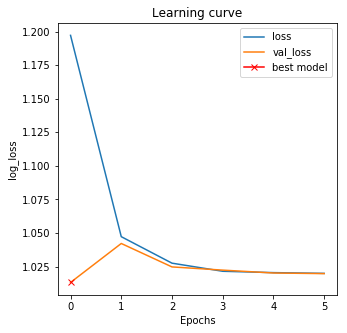

In [27]:
plot_model_scores(results)

In [28]:
model.load_weights(weights_path)
score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

Test score: -0.6026017069816589
Test accuracy: 0.9987529516220093


In [29]:
# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

11/11 [==============================] - 19s 2s/step


In [30]:
# Threshold predictions
t = 0.1
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:74: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


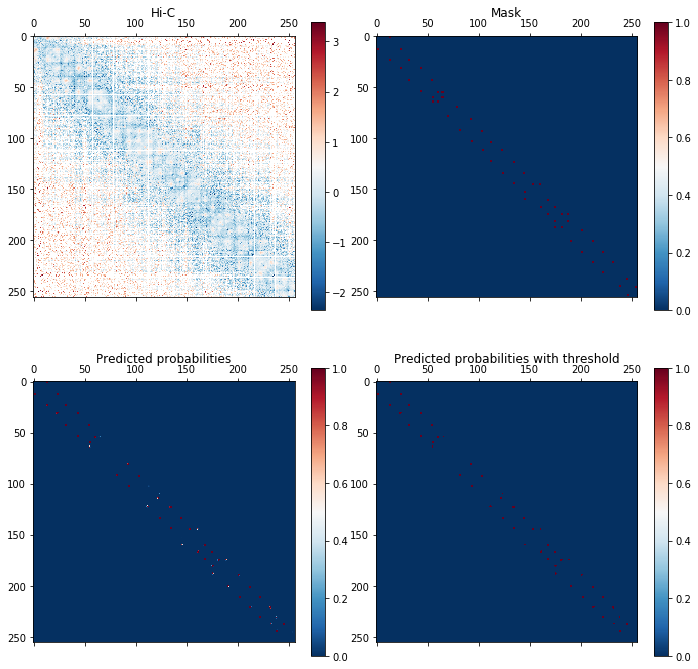

In [31]:
index = 1
loops_utils.plot_prediction_HiC(X_train[index],
                                y_train[index],
                                preds_train[index],
                                preds_train_t[index],
                                image_size=256)

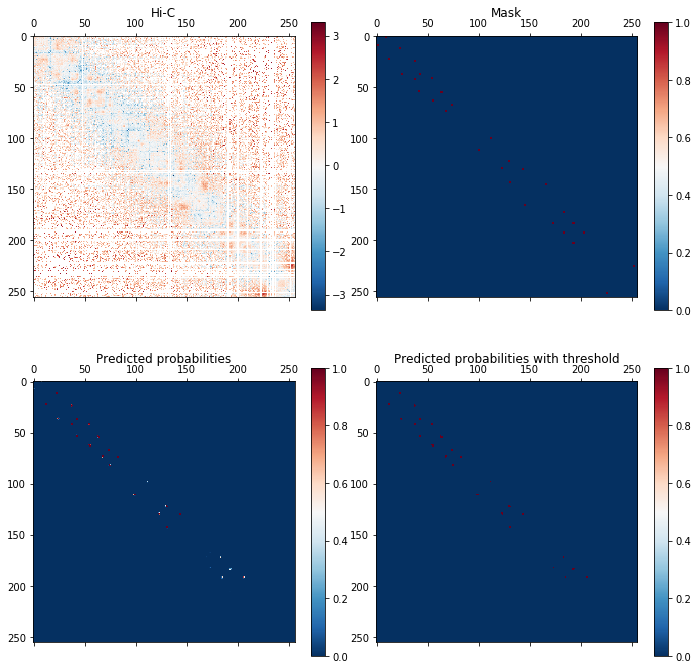

In [32]:
index = 0
loops_utils.plot_prediction_HiC(X_test[index],
                                y_test[index],
                                preds_test[index],
                                preds_test_t[index],
                                image_size=256)

Test score: -0.12787041068077087
Test accuracy: 0.9976626038551331
11/11 [==============================] - 19s 2s/step


/Users/alex/Desktop/ws/hse/diploma/loops/loops_utils.py:74: RuntimeWarning: divide by zero encountered in log
  raw = np.log(raw)


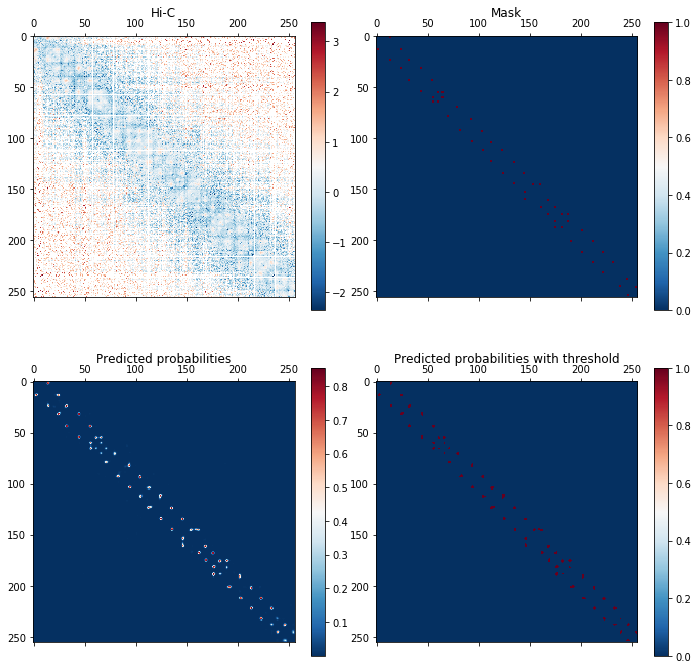

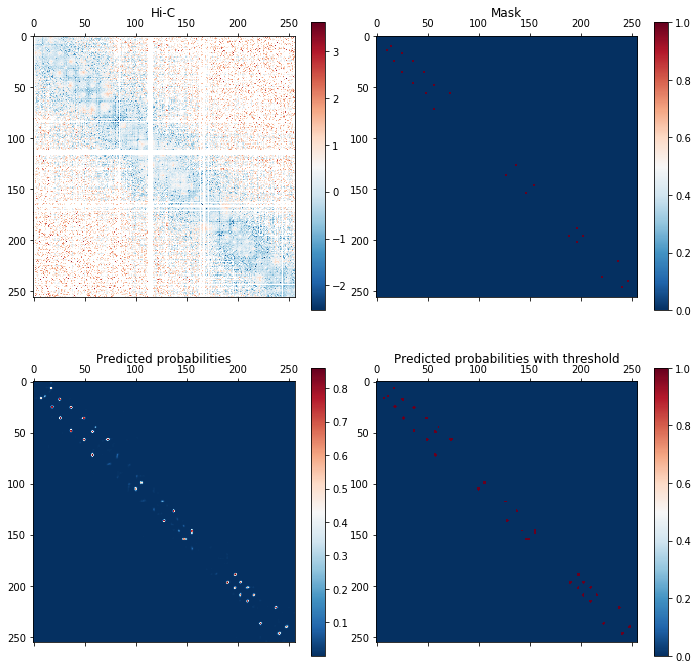

In [33]:
model.load_weights('weights/unet_corner_peak_half_step.h5')
score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
t = 0.1
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

index = 1
loops_utils.plot_prediction_HiC(X_train[index],
                                y_train[index],
                                preds_train[index],
                                preds_train_t[index],
                                image_size=256)

loops_utils.plot_prediction_HiC(X_test[index],
                                y_test[index],
                                preds_test[index],
                                preds_test_t[index],
                                image_size=256)

Test score: -0.05644333362579346
Test accuracy: 0.9980385303497314
11/11 [==============================] - 21s 2s/step


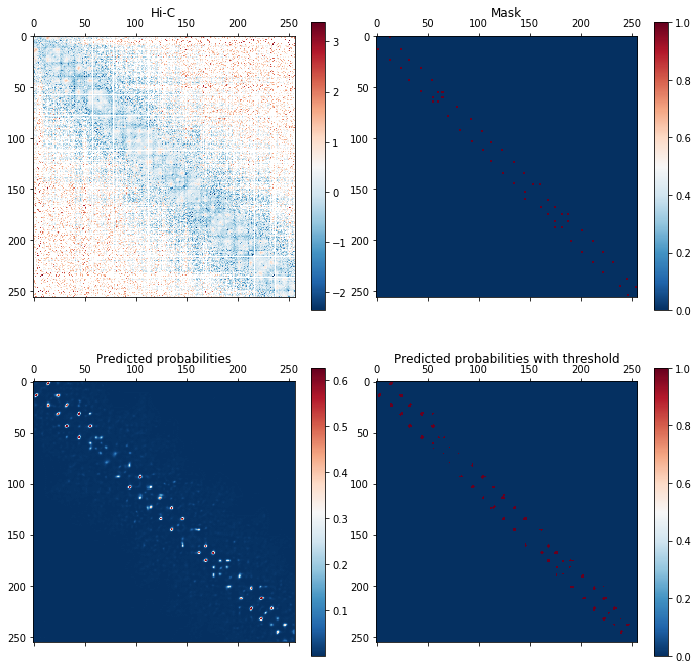

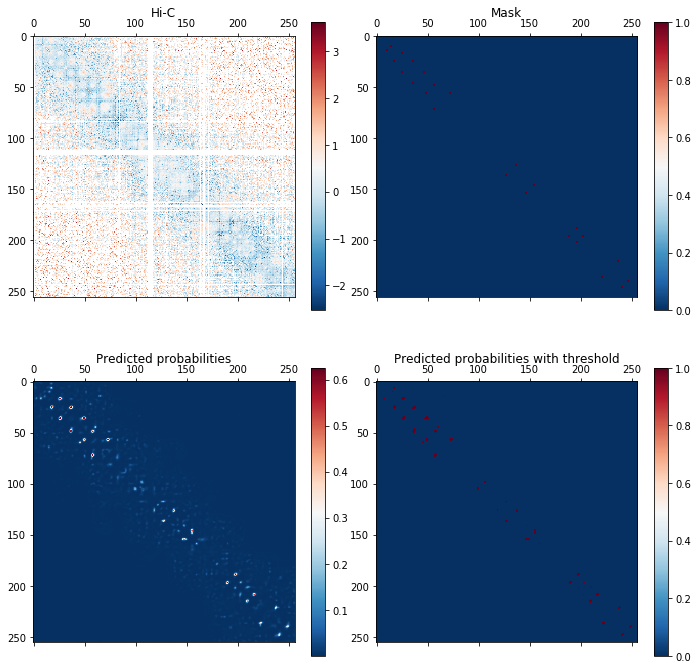

In [34]:
model.load_weights('weights/unet_corner_peak.h5')
score, acc = model.evaluate(X_test, y_test, verbose=0)
    
print('Test score:', score)
print('Test accuracy:', acc)

# Predict on train, val and test
preds_train = model.predict(X_train, verbose=1)
preds_test = model.predict(X_test, verbose=1)

# Threshold predictions
t = 0.1
preds_train_t = (preds_train > t).astype(np.uint8)
preds_test_t = (preds_test > t).astype(np.uint8)

index = 1
loops_utils.plot_prediction_HiC(X_train[index],
                                y_train[index],
                                preds_train[index],
                                preds_train_t[index],
                                image_size=256)

loops_utils.plot_prediction_HiC(X_test[index],
                                y_test[index],
                                preds_test[index],
                                preds_test_t[index],
                                image_size=256)